# ***Logistic Regression***

## ***Universidad Central***

## ***Maestría en analítica de datos***

## ***Métodos estadísticos para analítica de datos.***
## ***Docente: Luis Andrés Campos Maldonado.***

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels.formula.api as smf
from sweetviz import analyze
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, precision_recall_fscore_support
from sklearn.metrics import auc, roc_curve
from sklearn.linear_model import LinearRegression

plt.rcParams["figure.figsize"] = (15,6)
url_base="https://raw.githubusercontent.com/lacamposm/Metodos-Estadisticos/main/data/"

# ***Regresión logística***

## ***Introducción***

La ***regresión logística*** es una herramienta estadística ampliamente utilizada tanto para calcular probabilidades como para clasificar observaciones en distintas categorías. Este método permite modelar la probabilidad de que un evento ocurra (por ejemplo, el cumplimiento de un préstamo), en función de diferentes variables, y clasificar cada observación en una categoría determinada (como pagado o incobrable), de acuerdo con un umbral de probabilidad específico.

En una regresión logística se tiene una variable objetivo $Y$ la cual es binaria y es de interés para el investigador. Se quiere construir una función $f(X)$ donde $X=(X_1, \ldots, X_p)$ es un conjunto de variables explicativas que se utilizarán para pronosticar a $Y$.

En un modelo de regresión lineal logística, se usan las funciones del tipo:
$$\log \left(\frac{p}{1-p} \right)=\beta_0 +\beta_1X_1+\beta_2X_2+...+\beta_pX_p  $$ 

donde $p=P(Y=1)$

## ***Objetivos y plan de ruta.***

En este análisis, usaremos la regresión logística para explorar un conjunto de datos de préstamos, tomados de [LendingClub (LC) Statistics](https://www.lendingclub.com/info/download-data.action), que cubren préstamos emitidos junto con su estado actual. Nuestra objetivo es investigar cómo diferentes variables afectan la probabilidad de que un préstamo sea completamente pagado o dado de baja, permitiéndonos también clasificar cada préstamo en una de estas categorías con base en el modelo.

Idea del plan de ruta:

- Exploraremos el conjunto de datos para entender mejor cómo cada variable interactúa con el estado actual del préstamo.
- Revisaremos los fundamentos de la regresión logística como herramienta de clasificación.
- Ajustaremos y evaluaremos una serie de modelos de regresión logística para medir la significancia de cada variable en el resultado del préstamo.

## ***Dataset***
En el siguiente Dataset tenemos registros de préstamos aprobados, la columna `estado_del_prestamo` contiene la información si el préstamo fue pagado (`completamente_pagado`) o no (`dado_de_baja`), además de las siguientes features:


|FEATURE|                                                 DESCRIPCIÓN|
|:-------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|      ingreso_anual     |                                                 Los ingresos anuales autodeclarados proporcionados por el prestatario durante el registro.|
| estado_de_verificacion |                                          Indica si los ingresos fueron verificados, no verificados o si la fuente de ingresos fue verificada                                          |
|      anios_de_experiencia_laboral     |                       Duración del empleo en años. Los valores posibles están entre 0 y 10, donde 0 significa menos de un año y 10 significa diez o más años.                      |
|    tenencia_de_vivienda   |             El estado de propiedad de la vivienda proporcionado por el prestatario durante el registro u obtenido del informe de crédito: alquiler, propia, hipoteca, otro            |
|       tasa_de_interes      |                                                                           Tasa de interés del préstamo                                                                          |
|      monto_del_prestamo      | El monto del préstamo solicitado por el prestatario.|
|       proposito       |                                                           Una categoría proporcionada por el prestatario para la solicitud de préstamo.                                                          |
|         plazo        |                                             El número de pagos del préstamo. Los valores están expresados ​​en meses y pueden ser 36 o 60.                                             |
|        calificacion        |                                                                            Grado asignado del préstamo dado por la entidad                                                                            |

In [2]:
# Cargamos el DataSet
df_prestamos = pd.read_parquet(url_base + "Logistic_Regression_1.parquet")
df_prestamos.head()

,estado_del_prestamo,ingreso_anual,estado_de_verificacion,anios_de_experiencia_laboral,tenencia_de_vivienda,tasa_de_interes,monto_del_prestamo,proposito,plazo,calificacion
0,completamente_pagado,24000.0,verificado,10+ años,alquiler,10.65%,5000,tarjeta_de_credito,36 meses,B
1,dado_de_baja,30000.0,verificado_con_fuente,< 1 año,alquiler,15.27%,2500,auto,60 meses,C
2,completamente_pagado,12252.0,no_verificado,10+ años,alquiler,15.96%,2400,pequeno_negocio,36 meses,C
3,completamente_pagado,49200.0,verificado_con_fuente,10+ años,alquiler,13.49%,10000,otro,36 meses,C
4,completamente_pagado,80000.0,verificado_con_fuente,1 año,alquiler,12.69%,3000,otro,60 meses,B


Realizamos una exploración rápida de lo que nos ingresa al sistema:

                                             |          | [  0%]   00:00 -> (? left)


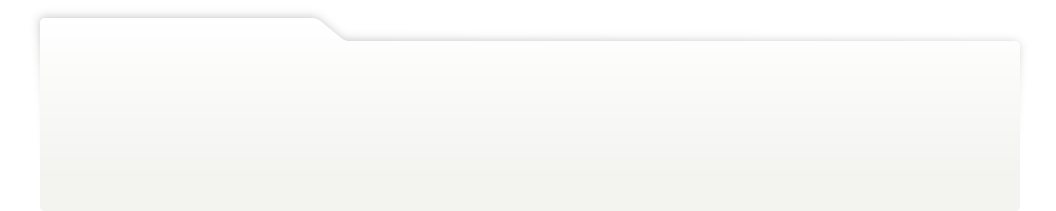
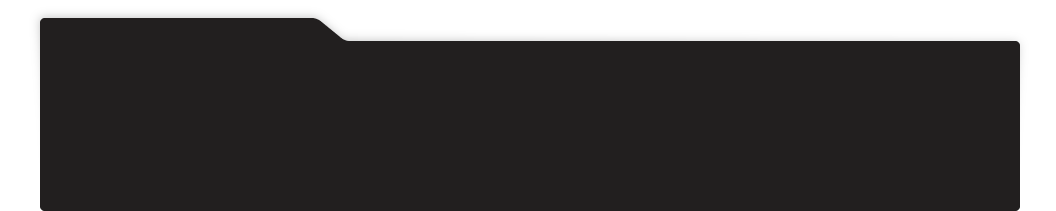
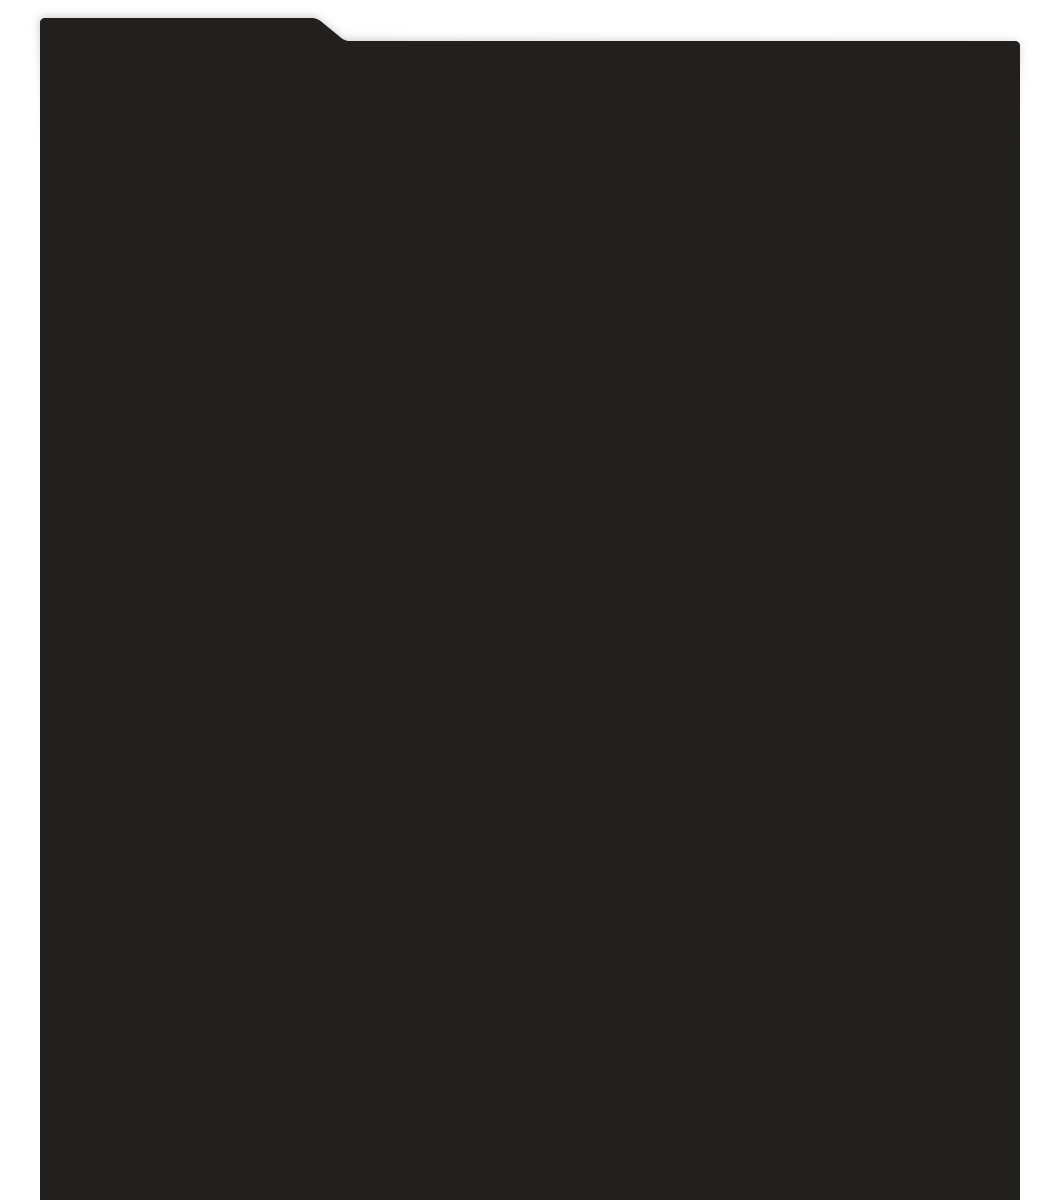
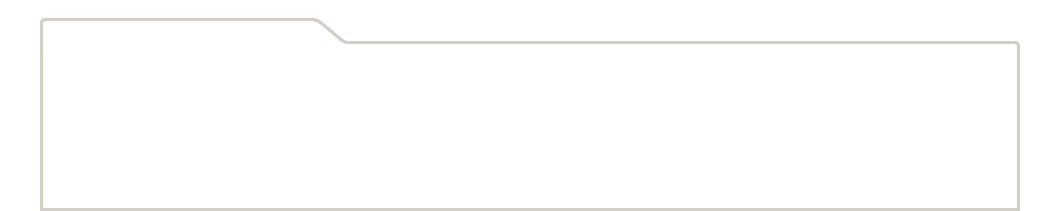
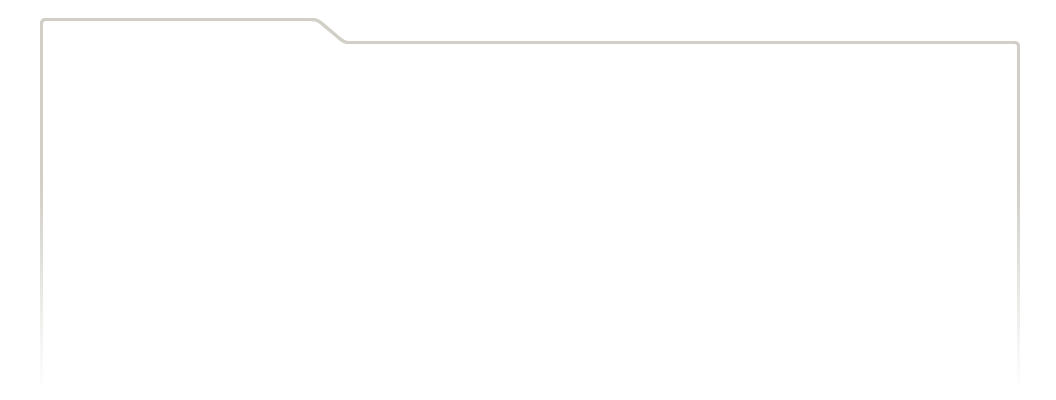
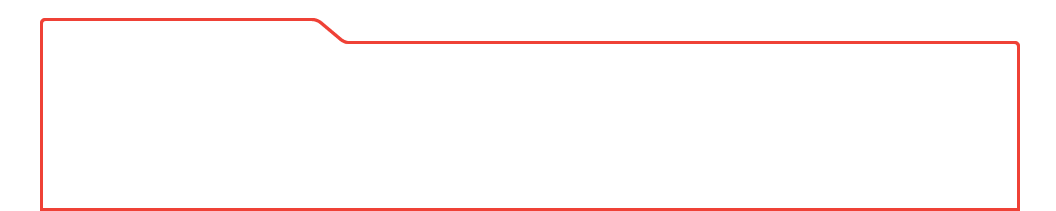
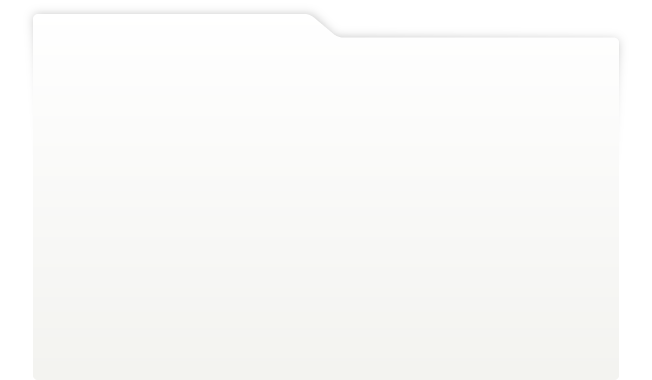
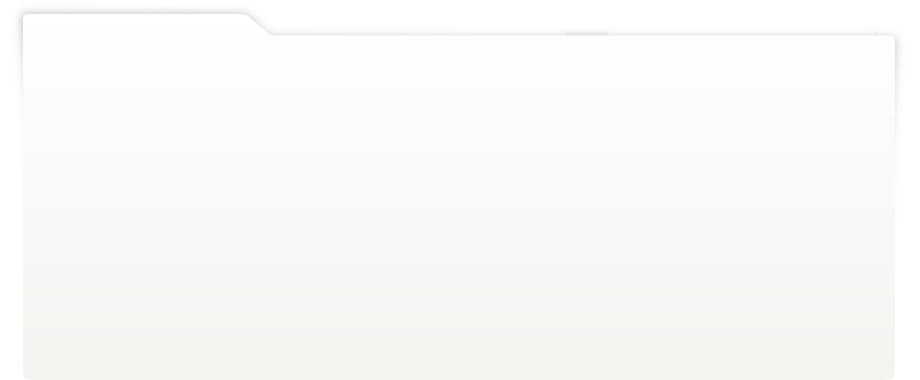
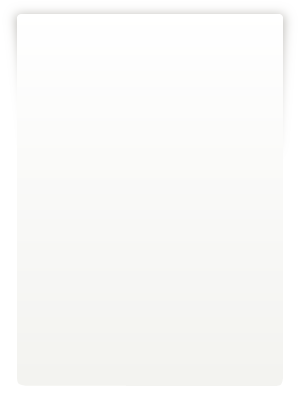
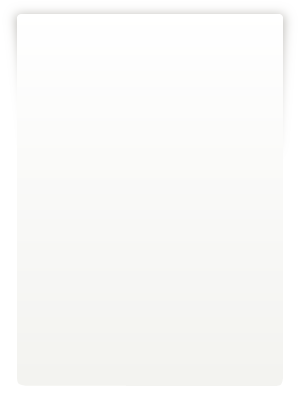
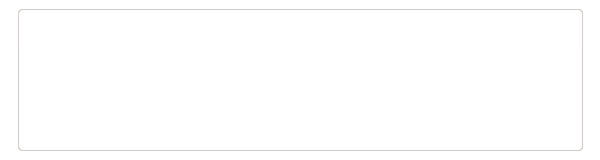
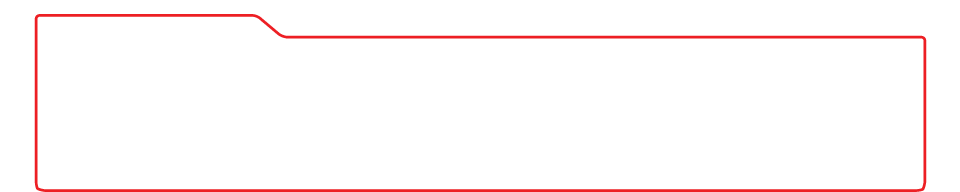
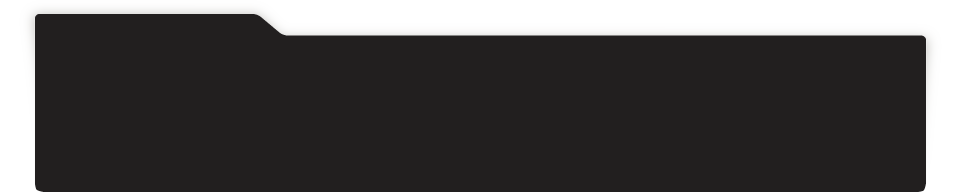
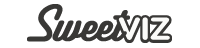
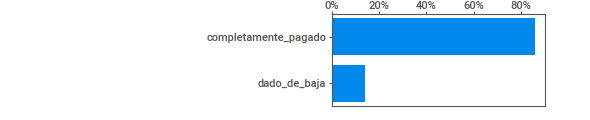
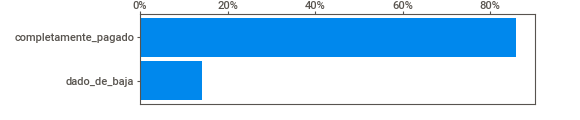
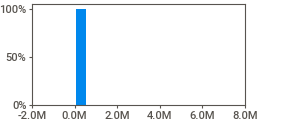
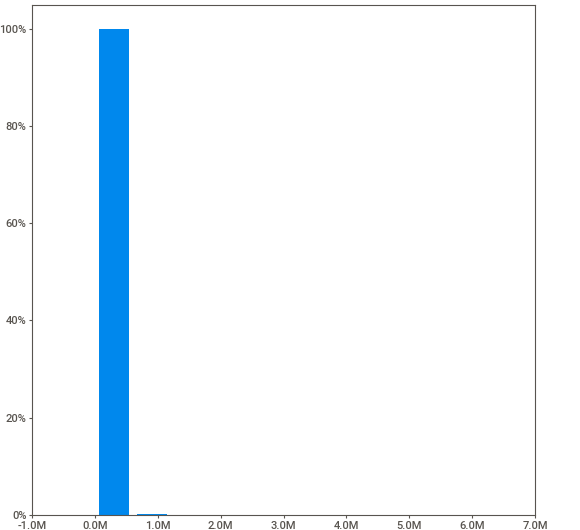
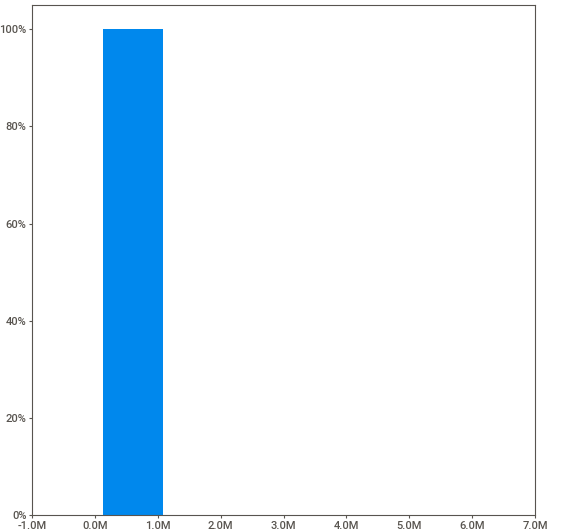
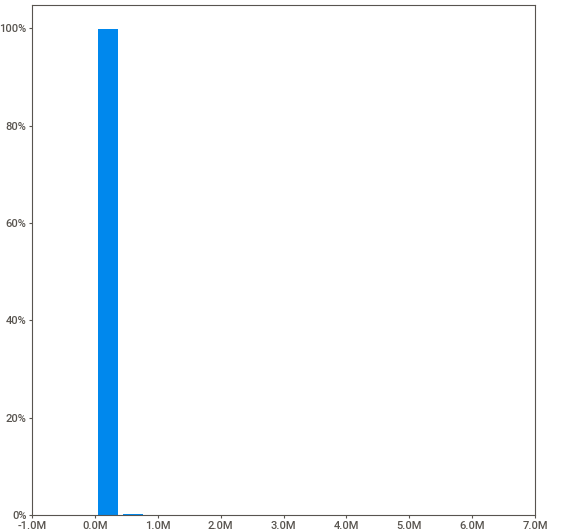
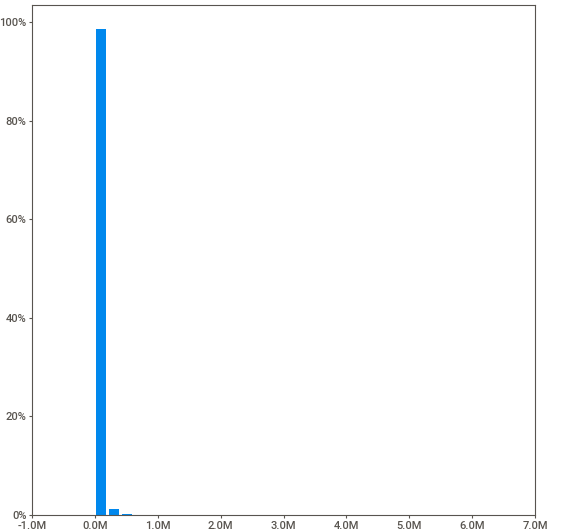
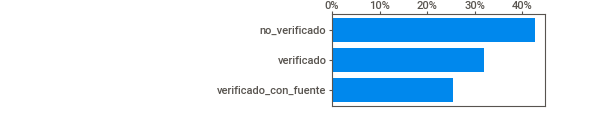
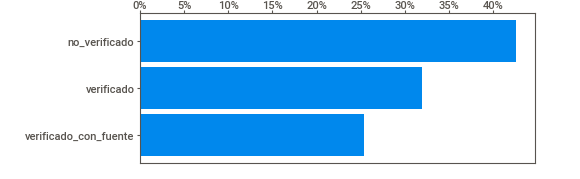
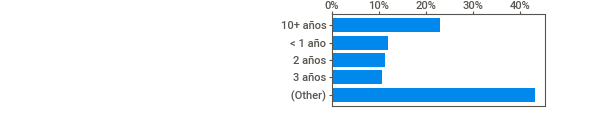
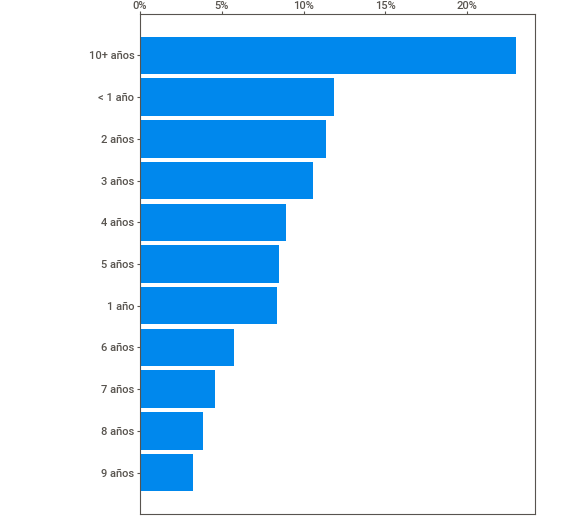
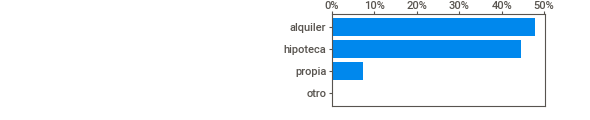
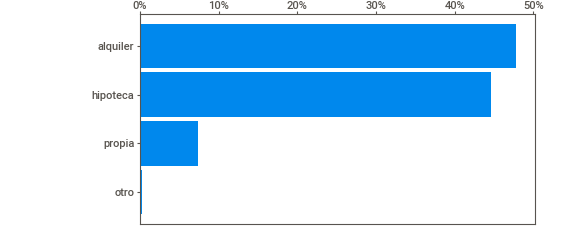
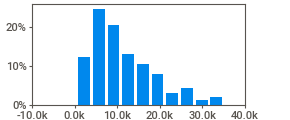
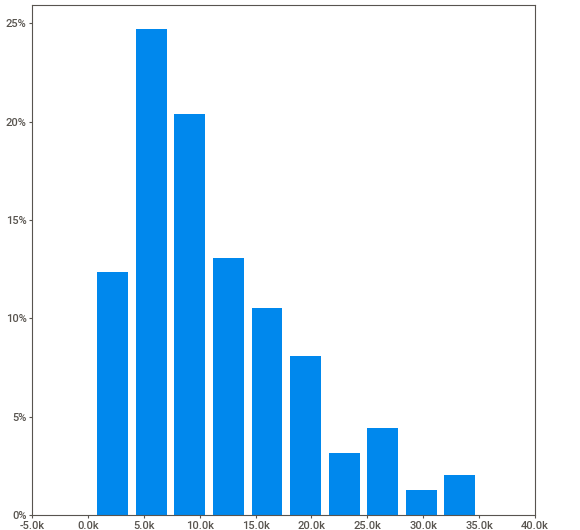
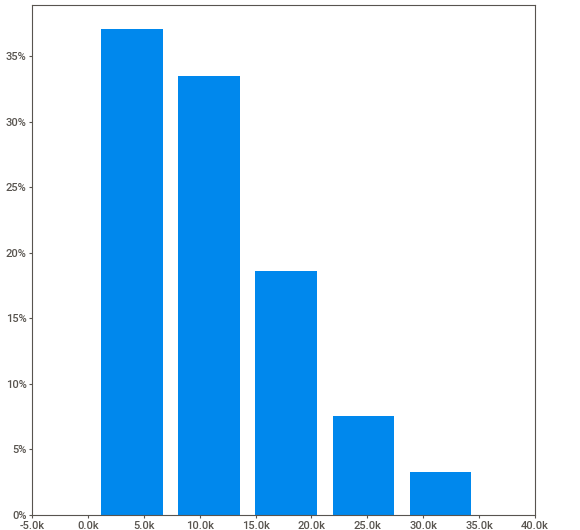
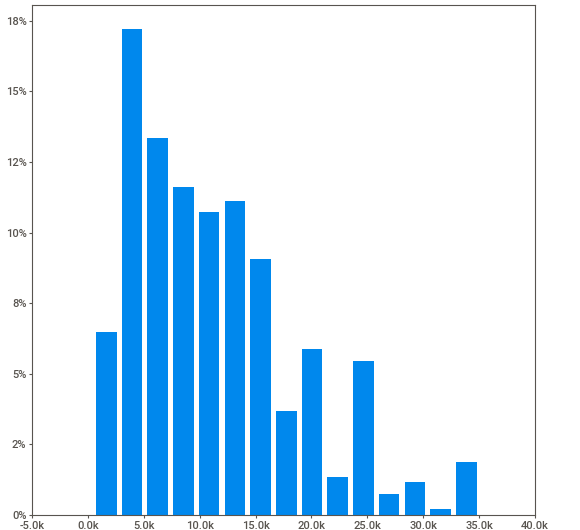
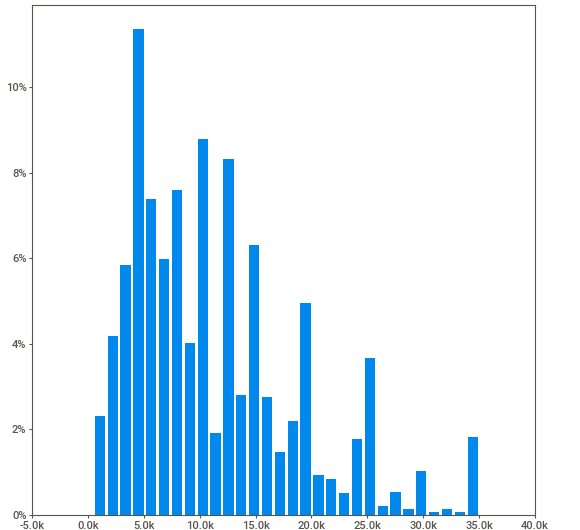
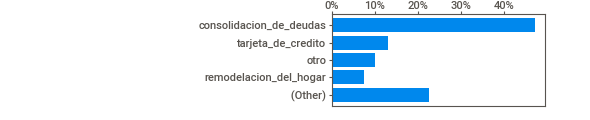
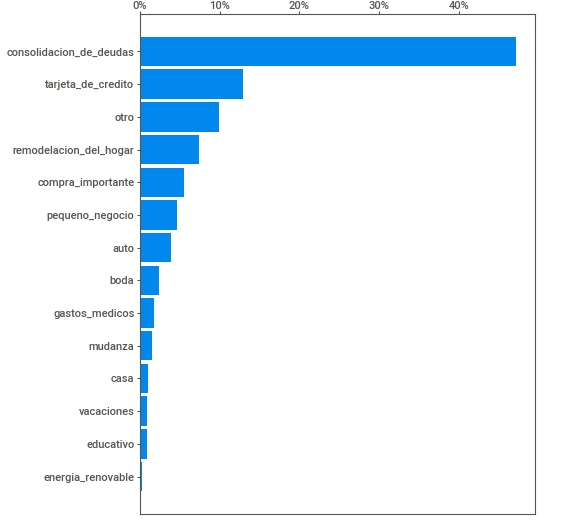
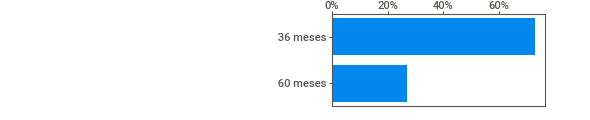
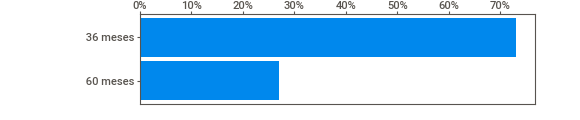
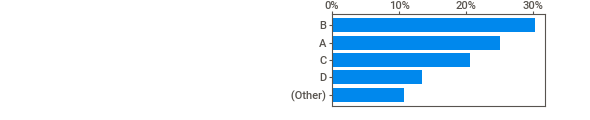
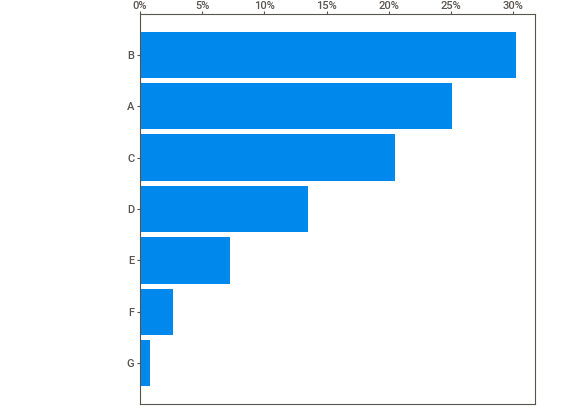
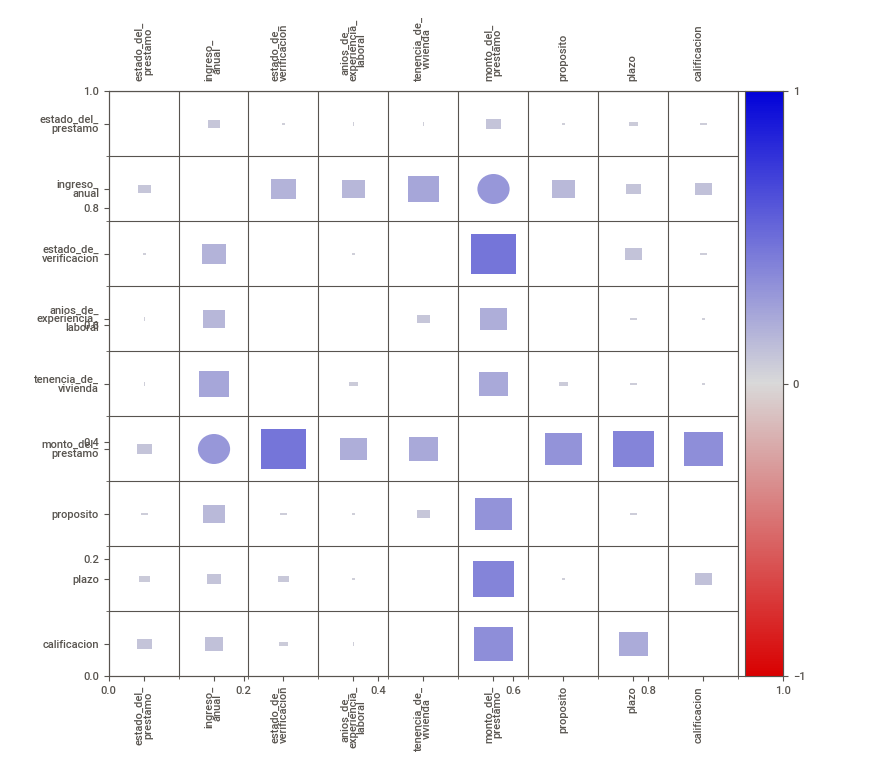
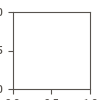

In [3]:
my_report = analyze(df_prestamos)
my_report.show_notebook()

In [4]:
plt.style.use("ggplot")

## ***Features versus Target.***

Realizamos un pequeño EDA para examinar la relación por pares entre la target `estado_del_prestamo` y cada una de las demás features numéricas. Exploramos las features `ingreso_anual`,` tasa_de_interes` y `monto_del_prestamo` en los usuarios que pagaron sus deudas (`completamente_pagado`) frente a los que no lo hicieron (`dado_de_baja`):

In [5]:
df_lr = df_prestamos.copy()
df_lr["tasa_de_interes"] = df_lr["tasa_de_interes"].str.replace("%", "").astype("float")
df_lr

,estado_del_prestamo,ingreso_anual,estado_de_verificacion,anios_de_experiencia_laboral,tenencia_de_vivienda,tasa_de_interes,monto_del_prestamo,proposito,plazo,calificacion
0,completamente_pagado,24000.0,verificado,10+ años,alquiler,10.65,5000,tarjeta_de_credito,36 meses,B
1,dado_de_baja,30000.0,verificado_con_fuente,< 1 año,alquiler,15.27,2500,auto,60 meses,C
2,completamente_pagado,12252.0,no_verificado,10+ años,alquiler,15.96,2400,pequeno_negocio,36 meses,C
3,completamente_pagado,49200.0,verificado_con_fuente,10+ años,alquiler,13.49,10000,otro,36 meses,C
4,completamente_pagado,80000.0,verificado_con_fuente,1 año,alquiler,12.69,3000,otro,60 meses,B
...,...,...,...,...,...,...,...,...,...,...
38700,completamente_pagado,110000.0,no_verificado,4 años,hipoteca,8.07,2500,remodelacion_del_hogar,36 meses,A
38701,completamente_pagado,18000.0,no_verificado,3 años,alquiler,10.28,8500,tarjeta_de_credito,36 meses,C
38702,completamente_pagado,100000.0,no_verificado,< 1 año,hipoteca,8.07,5000,consolidacion_de_deudas,36 meses,A
38703,completamente_pagado,200000.0,no_verificado,< 1 año,hipoteca,7.43,5000,otro,36 meses,A


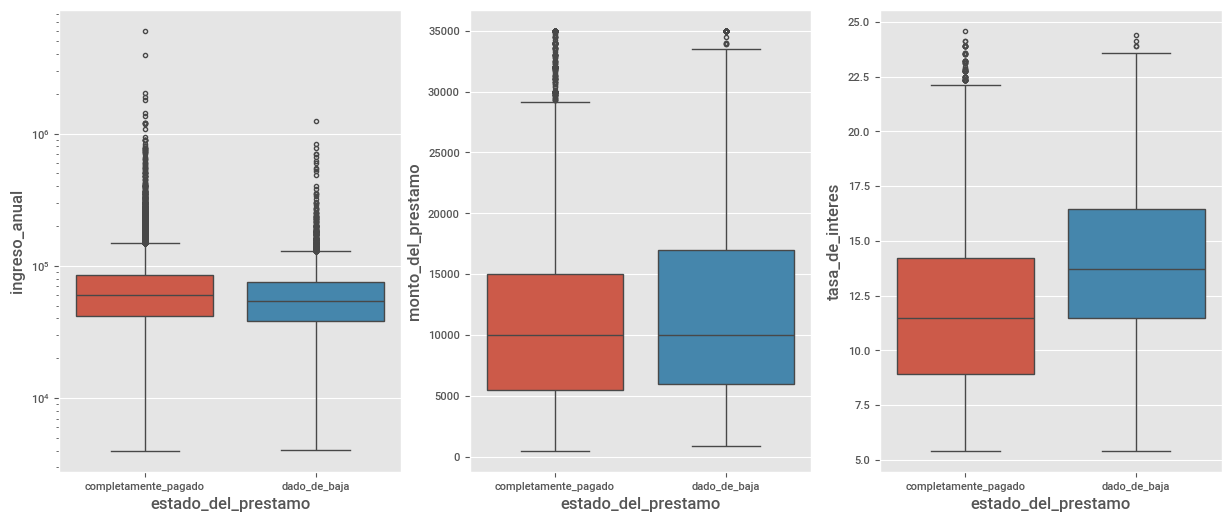

In [6]:
fig, ax = plt.subplots(1, 3)
sns.boxplot(y="ingreso_anual", x="estado_del_prestamo", data=df_lr, ax=ax[0], hue="estado_del_prestamo").set_yscale("log")
sns.boxplot(y="monto_del_prestamo", x="estado_del_prestamo", data=df_lr, ax=ax[1], hue="estado_del_prestamo")
sns.boxplot(y="tasa_de_interes", x ="estado_del_prestamo", data=df_lr, ax=ax[2], hue="estado_del_prestamo")
plt.show()

De los plots anteriores podemos ver que:

1. Un pequeño aumento en la mediana en `ingreso_anual` al comparar los usuarios que pagaron con los que no.

2. No vemos un cambio claro en la distribución de `monto_del_prestamo`. Los usuarios que pagaron sus deudas en su totalidad parecen tener montos de préstamos ligeramente más bajos.

3. La diferencia entre usuarios que no pagaron y usuarios que pagador en la distribución de `tasa_de_interes` es más marcada. El box-plot para los usuarios que pagaron es más baja que la de los usuarios que no. Este resultado es el esperado, ya que las tasas de interés más altas aumentarían la cantidad real de dinero que un usuario tendría que pagar.




***¿Qué features ayudan o ayudarían a decidir si se otorga el préstamo o no?***

In [7]:
# Vamos a hacer pruebas de t de medias.
# Hipótesis nula (H0): Las medias de las dos poblaciones son iguales.
# Hipótesis alternativa (Ha): Las medias de las dos poblaciones son diferentes.

# Prueba para cada feature numérica
for feature in df_lr.select_dtypes(np.number):
    a = df_lr[df_lr["estado_del_prestamo"]=="dado_de_baja"][feature]
    b = df_lr[df_lr["estado_del_prestamo"]=="completamente_pagado"][feature]
    T, p = ttest_ind(a,b)
    print(f"t-test para la feature: {feature}, tiene un p-valor de: {p:.5f}")

t-test para la feature: ingreso_anual, tiene un p-valor de: 0.00000
t-test para la feature: tasa_de_interes, tiene un p-valor de: 0.00000
t-test para la feature: monto_del_prestamo, tiene un p-valor de: 0.00000


En todos los casos el $p$-valor es pequeño, hay suficiente evidencia estadística para decir que las dos distribuciones tienen medias diferentes. Con esta "ayuda" podemos pensar en hacer uso de esta features como factor para decidir la aprobación de préstamos.

### ***Modelado de la situación.***

Vamos a considerar un modelo lineal de la siguiente forma:

$$p=\beta_0+\beta_1*\text{int rate}$$

Donde $p=P(Y=1)$, es decir, la probabilidad de que la persona haga el pago. Recordemos que los modelos lineales buscan estimar el valor esperado de la variable Target, en este como consideramos a `estado_del_prestamo` con distribución de Bernoulli.

In [8]:
# Formamos el Dataset de trabajo.
# En este caso debemos definir valores númericos para las categorías de la variables Target.
# Consideraremos que completamente_pagado = 1 y que dado_de_baja = 0
df1 = df_lr.copy()
df1 = df1[["estado_del_prestamo", "tasa_de_interes"]]
df1["estado_del_prestamo"] = df1["estado_del_prestamo"].apply(lambda x: 0 if x=="dado_de_baja" else 1)
display(df1.head())
px.box(df_lr, y="tasa_de_interes", color="estado_del_prestamo", template="plotly_white")

,estado_del_prestamo,tasa_de_interes
0,1,10.65
1,0,15.27
2,1,15.96
3,1,13.49
4,1,12.69


El box-plot para la feature `tasa_de_interes` muestra una diferencia entre los 2 niveles de la variable target. Más precisamente, el box-plot exhibe la diferencia entre usuarios con `dado_de_baja` y `completamente_pagado`, pues, para los usuarios con `completamente_pagado` los valores de  la feature lucen más "bajos" que para el caso de  `dado_de_baja`. Pensemos que si tenemos un sistema que solo usara esta característica para separar los grupos, tendríamos un solapamiento, algo que no es ideal.

In [9]:
# Regresión lineal
model_lm = LinearRegression()
X = df1.drop(columns=["estado_del_prestamo"])
y = df1["estado_del_prestamo"]

model_lm.fit(X, y)
model_lm.score(X, y)

0.040044469876966526

In [10]:
# Regresión lineal OTRA OPCIÓN
model_lm_sm = smf.ols(formula='estado_del_prestamo~tasa_de_interes', data=df1).fit()
print(model_lm_sm.summary())

                             OLS Regression Results                            
Dep. Variable:     estado_del_prestamo   R-squared:                       0.040
Model:                             OLS   Adj. R-squared:                  0.040
Method:                  Least Squares   F-statistic:                     1614.
Date:                 Sun, 03 Nov 2024   Prob (F-statistic):               0.00
Time:                         20:30:42   Log-Likelihood:                -13225.
No. Observations:                38705   AIC:                         2.645e+04
Df Residuals:                    38703   BIC:                         2.647e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.0849      

El $p$-valor de la prueba global de significancia del modelo muestra que si es posible hacer uso de esta feature para explicar las diferencias entre las probabilidades de la variable Target. Veamos la recta de ajuste:

In [11]:
px.scatter(
    df1, x="tasa_de_interes", y="estado_del_prestamo", trendline="ols", trendline_color_override="red", template="plotly_white"
).show()

Notemos que la recta dificilmente se ajusta al conjunto de puntos de la variable Target, además:


In [12]:
# Predicción del modelo con un valor de interés del 4.5%
model_lm.predict(pd.DataFrame({'tasa_de_interes': [4.5]}))

array([1.00080462])

En el caso anterior vemos que para una tasa de interés del $4.5\%$ se obtiene una probabilidad mayor que 1 (imposible!).

### ***odds o razón de probabilidades***

Los odds de un evento es la relación entre su probabilidad de éxito y su probabilidad de fracaso. Tomenos $Y~\sim Bernoulli(p)$, donde $p$ es la probabilidad de éxito, así:

$$
\text{Odds}(Y=1)=\frac{p}{1-p}
$$

- ***Ejemplo 1:*** Supongase que en una distribución de Bernoulli la probabilidad de que se obtenga un éxito es $0.8$, luego la probabilidad de fracaso será $0.2$, así:

$$
\text{Odds}=\frac{0.8}{0.2}=4
$$

Esto equivale a decir que se esperan 4 éxitos por cada 1 fracaso.

- ***Ejemplo 2:*** De igua forma, suponga ahora que en una distribución de Bernoulli la probabilidad de que se obtenga un éxito es $0.3$, luego la probabilidad de fracaso será $0.7$, así:

$$
\text{Odds}=\frac{0.3}{0.7}=\frac{3}{7}
$$

Esto equivale a decir que se esperan 3 éxitos por cada 7 fracasos.


In [13]:
# Gráfica de los odds.
values_p = np.linspace(0.0001, 0.999, 1000)
odds = (values_p)/(1-values_p)

(
    px.line(x=values_p, y=odds, template="plotly_white")
    .update_xaxes(title_text="Valores de la probabilidad")
    .update_yaxes(title_text="odds")    
)

El plot anterior muestra como los odds toman valores de $(0,∞)$, deseamos que también se toman valores negativos, que es lo que secude en un modelo lineal.

### ***Función logit***


Aunque hemos logrado tomar cualquier valor real positivo, aún debemos lograr que se tomen valores negativos para ajustar un modelo lineal.

Vamos a considerar la función:

$$logit(p)=\ln\left(\frac{p}{1-p}\right)$$

Esta función tiene dominio en $(0,1)$ y rango en todos los reales.

### ***Odds ratio***

El concepto clave es entender los ***odds ratio***, esto es no otra cosa que un cociente de ***odds***. Vamos a suponer que tenemos una feature categórica $X$ de dos niveles (0 y 1). Luego los ***odds ratio*** vienen dados por: 

$$\text{odds ratio}=\frac{odds(p(Y=1|X=1))}{odds(p(Y=1|X=0))}$$

Lo anterior se interpreta como:

***los odds de que $Y=1$ cuando $X=1$ versus los odds de $Y=1$ cuando $X=0$.***

Por ejemplo, si ***odds ratio*** es igual a 2, entonces ***los odds para $Y=1$ son dos veces mayores cuando $X=1$ versus cuando $X=0$.*** 

***Nota:*** Se debe trabajar en términos de ***odds ratio*** por que los coeficientes $β_j$ en la regresión logística son el logaritmo natural de los ***odds ratio*** para $X_j$.

In [14]:
# Gráfica del log de los odds.
log_odds = np.log(odds)

(
    px.line(x=values_p, y=log_odds, template="plotly_white")
    .update_xaxes(title_text="Valores de la probabilidad")
    .update_yaxes(title_text="Logit de p")    
)

In [15]:
# Plot log(odds ratio) vs. odds ratio
odds = odds[odds>1]
log_odds = np.log(odds)

(
    px.line(x=log_odds, y=odds, template="plotly_white")
    .update_xaxes(title_text="log(odds ratio)")
    .update_yaxes(title_text="odds ratio")    
)

El plot anterior muestra la relación entre los odds ratio y los logaritmos de los odds ratio  para
razones de probabilidad mayores que 1. Debido a que los coeficientes están en la escala logarítmica, un aumento de 1 en el coeficiente da como resultado un aumento de $exp(1)≈2,72$ en los odds ratios.

## ***Nuestro modelo de regresión logística simple.***

Con todo lo comentado anteriormente, para nuestro problema en particular, tomemos el modelo:

$$\log\left(odds(Y=1)\right)=\beta_0+\beta_1*\text{int rate}$$

Este modelo relaciona la probabilidad $p=P(Y=1)$ y el modelo lineal general.

In [16]:
df1

,estado_del_prestamo,tasa_de_interes
0,1,10.65
1,0,15.27
2,1,15.96
3,1,13.49
4,1,12.69
...,...,...
38700,1,8.07
38701,1,10.28
38702,1,8.07
38703,1,7.43


In [17]:
# Implementación Logistic Regression logit.
lr_logit1 = smf.logit(formula="estado_del_prestamo ~ tasa_de_interes", data=df1).fit()
print(lr_logit1.summary())

Optimization terminated successfully.
         Current function value: 0.386210
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     estado_del_prestamo   No. Observations:                38705
Model:                           Logit   Df Residuals:                    38703
Method:                            MLE   Df Model:                            1
Date:                 Sun, 03 Nov 2024   Pseudo R-squ.:                 0.04865
Time:                         20:30:43   Log-Likelihood:                -14948.
converged:                        True   LL-Null:                       -15713.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.7810      0.056     67.091      0.000       3.671       3.891
tasa_d

### ***Interpretación de los coeficientes en la salida de una regresión logística***

El signo del coeficiente de regresión aún representa la dirección de influencia de una variable específica: ***un coeficiente positivo significa que la probabilidad de pago aumentará si la variable asociada aumenta y viceversa.***

Por supuesto, otra parte importante de la información al interpretar un modelo de regresión logística es el $p$-valor para cada coeficiente de regresión. 

En todos los casos se está contrastando las hipótesis:

$$H_0: \beta_i=0$$
$$vs$$
$$H_1: \beta_i \neq 0$$

Es decir, ***rechazar la hipótesis nula, significa que la diferencia en la probabilidad de pago está asociada con cambios en la variable correspondiente.***

Nuestro modelo ajustado será:

$$\ln\left(odds\right)=3.7810-0.1538*\text{tasa\_de\_interes}$$

Supongamos además, que tenemos un incremento unitario en la feature `tasa_de_interes` pasando de una cantidad $x_{i}$ a $x_i+1$, por lo tanto:


$$\frac{odds_{x_i+1}}{odds_{x_i}}=exp(-0.1538)=0.8574$$

Es decir, por cada 100 éxitos que se tenían cuando $\text{tasa\_de\_interes}=x_i$, se paso a tener 85 éxitos, es decir, ***los odds de pagar el préstamo decrecen aproximadamente en un $15\%$, por cada aumento de un punto en la tasa de interés.***


***El `Pseudo R-squ.`. es una métrica similar a R-cuadrado para modelos lineales. Si este número es grande, entonces las variables en el modelo explican una gran parte de los "impulsores" de la tendencia de las personas a pagar su deuda. En este caso, la métrica es solo del $4.8\%$, lo que significa que podemos mejorar mucho nuestro modelo.***

In [18]:
# Implementación segundo modelo LR con una variable categórica.
df2 = df_lr.copy()
df2 = df2[["estado_del_prestamo", "tenencia_de_vivienda", "tasa_de_interes"]]
df2["estado_del_prestamo"] = df2["estado_del_prestamo"].apply(lambda x: 0 if x=="dado_de_baja" else 1)
df2["tenencia_de_vivienda"] = df2["tenencia_de_vivienda"].astype(pd.CategoricalDtype(categories=["alquiler", "propia", "hipoteca", "otro"]))

lr_logit2 = smf.logit(formula="estado_del_prestamo ~ tasa_de_interes + tenencia_de_vivienda", data=df2).fit()
print(lr_logit2.summary())

Optimization terminated successfully.
         Current function value: 0.386064
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     estado_del_prestamo   No. Observations:                38705
Model:                           Logit   Df Residuals:                    38700
Method:                            MLE   Df Model:                            4
Date:                 Sun, 03 Nov 2024   Pseudo R-squ.:                 0.04901
Time:                         20:30:44   Log-Likelihood:                -14943.
converged:                        True   LL-Null:                       -15713.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            3.7392      0.059  

***Interpretación:***

Como la feature `tenencia_de_vivienda` tiene los niveles: alquiler, propia, propia y otro y el coeficiente de regresión para `tenencia_de_vivienda[T.hipoteca]` es $0.0931$, entonces:


$$\frac{odds(hipoteca)}{odds(alquiler)}=exp(0.0931)=1.0975$$

***Luego, los odds para `hipoteca` es 1.0975 veces más que los odds para `alquiler`. Es decir, la ventaja para finalmente pagar el crédito es $9\%$ más en `hipoteca` que en `alquiler`***

Con las demás variables categóricas es muy similar el análisis.




### ***Predicciones***

Recordemos que estamos estimando la probabilidad de que la variable Target (`estado_del_prestamo`), sea un éxito, dada la información en las features `tasa_de_interes` y `tenencia_de_vivienda`. Las predicciones de la probabilidad se encuentran con la expresión:

$$\hat{p}=\frac{1}{1+exp(-\hat{Y})}$$

Donde:


1. $\hat{Y} = 3.7391 + 0.0058 \times \text{tenencia\_de\_vivienda[T.propia]} + 0.0931 \times \text{tenencia\_de\_vivienda[T.hipoteca]} - 0.3468 \times \text{tenencia\_de\_vivienda[T.otro]} - 0.1536 \times \text{int\_rate}$


2. $\hat{p}$ es la estimación de $P(Y=1|\text{regresores})$

In [19]:
# Parámetros estimados.
lr_logit2.params

Intercept                           3.739158
tenencia_de_vivienda[T.propia]      0.005786
tenencia_de_vivienda[T.hipoteca]    0.093087
tenencia_de_vivienda[T.otro]       -0.346762
tasa_de_interes                    -0.153589
dtype: float64

In [20]:
# Predicciones vía el modelo de regresión logística.
predict_lr_logit2 = lr_logit2.predict(df2.drop(columns=["estado_del_prestamo"]))
predict_lr_logit2

0        0.891237
1        0.801207
2        0.783787
3        0.841208
4        0.856941
           ...   
38700    0.930396
38701    0.896624
38702    0.930396
38703    0.936498
38704    0.836593
Length: 38705, dtype: float64

Notemos que el modelo ***NO predice*** la categoría de la observación, solo muestra la ***probablidad de ser parte de la categoría 1 de la variable Target***.

### ***Evaluación de modelos de clasificación***

En el modelado predictivo se acostumbra a entrenar varios modelos diferentes, luego evaluar los diferentes modelos en el conjunto `test` y evaluar su desempeño. La idea de evaluación del modelo será saber qué modelo produce la información más precisa y útil en las predicciones.

In [21]:
# log(odds) son los valores ajustados del modelo.
log_odds = lr_logit2.fittedvalues
log_odds.head()

0    2.103434
1    1.393853
2    1.287876
3    1.667241
4    1.790112
dtype: float64

In [22]:
log_odds = lr_logit2.fittedvalues
p_hat = 1/(1 + np.exp(-log_odds))
# True labels
true_label = df2["estado_del_prestamo"]
# Corte en 0.5: 1 si es mayor o igual 0.5 y 0 en otro caso.
prediction = round(p_hat).astype("int")
pd.DataFrame({"proba": p_hat, "predict": prediction, "true_label": true_label})

,proba,predict,true_label
0,0.891237,1,1
1,0.801207,1,0
2,0.783787,1,1
3,0.841208,1,1
4,0.856941,1,1
...,...,...,...
38700,0.930396,1,1
38701,0.896624,1,1
38702,0.930396,1,1
38703,0.936498,1,1


### _**[Matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)**_

Un resumen muy importante de la clasificación es la matriz de confusión. La matriz de confusión es una tabla que muestra el número de predicciones correctas e incorrectas etiquetadas en los siguientes cuatro términos:


- ***True positives (TP):*** Es el número de predicciones corretas del modelo en la categoría 1.
- ***False positives (FP):*** Es el número de predicciones que el modelo etiquetó con 1 cuando la categoría real era 0.

_Los dos anteriores corresponderán a la primera columna de nuestra construcción de la matriz de confusión._


- ***True negatives (TN):*** Es el número de predicciones correctas del modelo en la categoría 0.
- ***False negative (FN):*** Es el número de predicciones que el modelo etiquetó con 0 cuando la categoría real era 1.

_Los dos anteriores corresponderán a la segunda columna de nuestra construcción de la matriz de confusión._



<div align="center"><img src='https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/images/confution_matrix.png' width=400>

_**Tomado de: [https://towardsdatascience.com/confusion-matrix-un-confused-1ba98dee0d7f](https://towardsdatascience.com/confusion-matrix-un-confused-1ba98dee0d7f)**_
</div>

[[33265     0]
 [ 5439     1]]


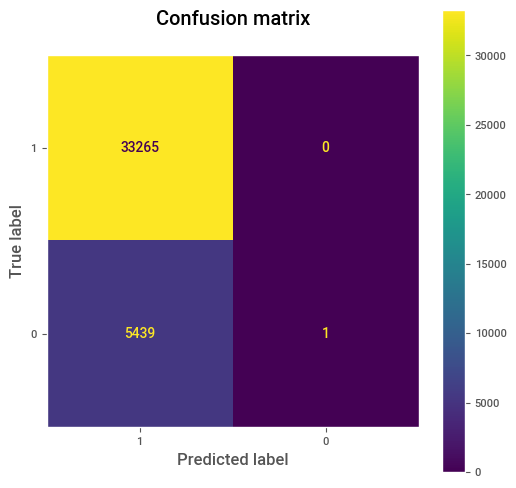

In [23]:
# Confusion matrix
cm = confusion_matrix(true_label, prediction, labels=[1,0])
print(cm)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax)
plt.grid(False)
plt.title("Confusion matrix\n")
plt.show()

***Nota:***

1. La suma en la filas proporciona la realidad de la información, es decir, la suma de cada fila proporciona la cantidad de verdaderos miembros en las correspondientes etiquetas.

2. La suma en las columnas proporciona las predicciones del modelo, es decir, la suma de cada columna proporciona la cantidad de miembros predecidos en las correspondientes etiquetas.

### _**[Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)**_

Una forma sencilla de medir el rendimiento de la clasificación es contar la proporción de predicciones que son correctas, es decir, medir la precisión. El `accuracy` es simplemente una medida de error total:


$$accuracy =\frac{TP+TN}{TP+FN+FP+TN}$$


En la mayoría de los algoritmos de clasificación, a cada registro se le asigna una _“probabilidad estimada de
ser de la categoría 1.”_  El punto de decisión predeterminado, o _cutoff_, suele ser 0,50 o 50 %. Si la probabilidad está por encima de 0,5, la clasificación es "1"; de lo contrario, es "0". 

In [24]:
# accuracy de sklearn  # Logra clasificar correctament cerca del 86% de los registros
# ¿Piensa usted que con este resultado es suficiente?
print(f"Precision model lr_logit2 ---> {accuracy_score(true_label, prediction):.4f}")

Precision model lr_logit2 ---> 0.8595


### ***Precision, Recall y specificity.***


- _**[Precision:](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)**_ Mide la exactitud de una predicción positiva (categoría 1). Es decir, la proporción de acierto en las predicciones de la categoría 1 del modelo.

$$precision=\frac{TP}{TP+FP}$$



- _**[Recall (sensitivity):](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)**_ Mide la fuerza del modelo para predecir un resultado positivo (1), es decir, la proporción de los verdaderos 1 que el modelo identifica correctamente. El recall también es llamado ***True positive rate (TPR)***.

$$recall=\frac{TP}{TP+FN}$$



- _**[specificity:](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)**_ Mide la capacidad de un modelo para predecir un resultado negativo (0), es decir, la proporción de verdaderos 0 que el modelo identifica correctamente como 0.

$$specificity=\frac{TN}{TN+FP}$$

- _**[FPR:](https://en.wikipedia.org/wiki/False_positive_rate)**_  La tasa de falsos positivos, ***mide la proporcion de los verdaderos 0's que el modelo clasifica mal***, se define como $FPR=1-specificity$, luego:

$$FPR=\frac{FP}{FP+TN}$$

In [25]:
# precision_score
print(f"precision score: {precision_score(true_label,prediction):.4f}")
# recall_score
print(f"recall score: {recall_score(true_label, prediction):.4f}")
# specificity
specificity = precision_recall_fscore_support(true_label,prediction)[1][0]
print("FPR:", round(1 - specificity, 4))

precision score: 0.8595
recall score: 1.0000
FPR: 0.9998


### _**[Curva ROC.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)**_

Existe una compensación entre el ***recall*** y la ***specificity***. Capturando más 1s
generalmente significa clasificar erróneamente más 0 como 1. La métrica que captura esta compensación es la curva de  "Receiver Operating Characteristics” (Características operativas del receptor), conocida como la curva ROC. La curva ROC traza el ***TPR*** en el eje $y$ contra ***FPR*** en el eje $x$. La curva ROC muestra el equilibrio entre el ***recall*** y la ***specificity*** a medida que cambia el límite para determinar cómo clasificar un registro.

El proceso para calcular la ROC curva es:

1. Ordene los registros por la probabilidad predicha de ser un 1, comenzando con el más probable y terminando en el menos probable. 

2. Calcule para cada corte ***FPR*** y el ***TPR***, luego se gráfican estos puntos.

In [26]:
# Situación ideal
cm = confusion_matrix(true_label, true_label, labels=[1,0])
print("TPR:", cm[0,0]/sum(cm[0]))
print("FPR:", cm[1,0]/sum(cm[1]))

TPR: 1.0
FPR: 0.0


In [27]:
# La peor situación.
bad_label = true_label.apply(lambda x: 0 if x==1 else 1)
cm = confusion_matrix(true_label, bad_label, labels=[1,0])
print("TPR:", cm[0,0]/sum(cm[0]))
print("FPR:", cm[1,0]/sum(cm[1]))

TPR: 0.0
FPR: 1.0


In [28]:
#  Situación de elección al azar (sin ningún criterio)
temp = np.random.binomial(1, 0.5, size=len(true_label))
cm = confusion_matrix(true_label, temp, labels=[1,0])
print("recall:", cm[0,0]/sum(cm[0]))
print("specificity:", cm[1,1]/sum(cm[1]))
print("1- specificity:", cm[1,0]/sum(cm[1]))

recall: 0.49956410641815724
specificity: 0.5040441176470588
1- specificity: 0.4959558823529412


#### ***Ejemplo:***

Calcule el _recall (TPR)_ y la _specificity (TNR)_ para el modelo `lr_logit2` con cut-off de $p=0.8, 0.85, 0.9$. Comente en todos los casos. ¿Cuál de estos valores de corte crees que es mejor? Justifique.

In [29]:
# Función para diferentes cut-off.
def cm_cut_off(true_label, p_hat, cut_value):
    """
    """  
    cut = p_hat.apply(lambda x: 1 if x>cut_value else 0)
    cm = confusion_matrix(true_label, cut, labels=[1,0])
    TPR, TNR = cm[0,0]/(sum(cm[0])), cm[1,1]/sum(cm[1])
    print(f"Para el corte: {cut_value}")
    print(f"TPR={TPR:.4f} y TNR={TNR:.4f}") 
     
    return

In [30]:
# cut-off de 0.8
cm_cut_off(true_label, p_hat, cut_value=0.8)

Para el corte: 0.8
TPR=0.8403 y TNR=0.3290


Con un cut-off de $0.8$, tenemos un TPR alto y un TNR bajo, luego, este límite clasificaría correctamente a la mayoría de los "buenos" prestarios, pero también dejaría mal clasificados a gran parte de los morosos, esto podría tener problemas pues se podría perder bastante dinero.

In [31]:
# cut-off de 0.9
cm_cut_off(true_label, p_hat, cut_value=0.9)

Para el corte: 0.9
TPR=0.3564 y TNR=0.8443


Con $p=0.9$ se detectaría correctamente gran parte de los morosos, pero se negarían muchos prestamos a usuarios que probablemente pagarán. Así, se podría perder clientes pues descartamos "buenos" (que terminan pagando) clientes.

In [ ]:
# cut-off de 0.85
cm_cut_off(true_label, p_hat, cut_value=0.85)

Para el corte: 0.85
TPR=0.6710 y TNR=0.5478


Siendo más conservadores, con $p=0.85$ se detectará un $67\%$ de los "buenos" prestamistas y cerca del $54\%$ de los morosos. Esta podría ser una alternativa pues no perderíamos gran parte de clientes y el riesgo estaría maso menos contralado. 


***Hay una compensación constante entre TPR y TNR. Por lo general, es difícil encontrar una regla con TPR y TNR altos al mismo tiempo. Las personas elegirán priorizar uno de ellos según el escenario particular. Por ejemplo, en nuestro caso, TNR suele ser más importante que TPR, ya que preferimos evitar prestar a los morosos que dejar de prestar a un buen candidato. En cualquier caso debe ser el cliente (entidad que contrata el servicio de analítica) que enfoque tomar, uno más seguro u otro más arriesgado.***

### ***Construcción del sistema perfecto de clasificación.***

El clasificador ideal haría un excelente trabajo al clasificar los 1, sin clasificar erróneamente 0 como 1. La curva ROC de la situación ideal es la siguiente:

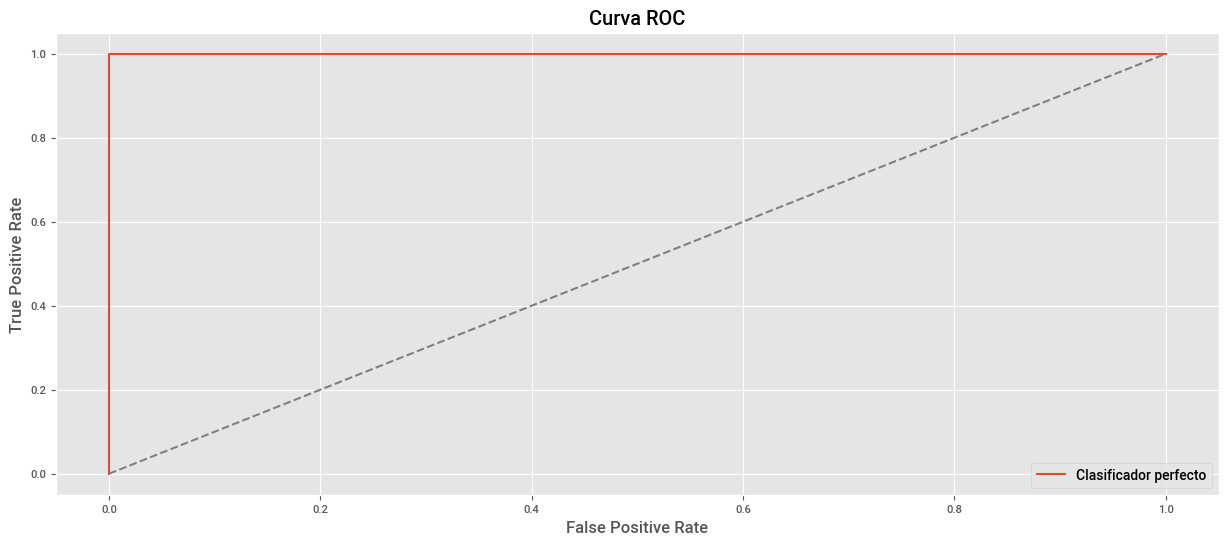

In [33]:
plt.plot((0,0,1),(0,1,1), label="Clasificador perfecto")
plt.title("Curva ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot((0,1), (0,1), ls="--", color="grey")
plt.legend()
plt.show()

***Vamos o buscar recrear la situación ideal con un sistema inteligente.***

***Paso 1:***  Al tener unas probabilidades estimadas, debemos seleccionar un ***cut-off*** para que nuestro sistema prediga 1s y 0s. Vamos a iniciar con probabilidad de 1, es decir todos los registros el sistema los clasifica como 0. 



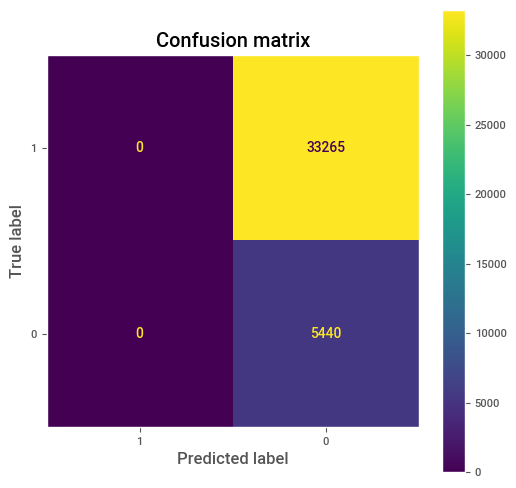

In [34]:
# Lo que sucede en nuestro sistema actual.
all_zeros = pd.Series([0 for i in range(len(true_label))])
cm = confusion_matrix(true_label, all_zeros, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.grid(False)
plt.title("Confusion matrix")
plt.show()

Con la matriz de confusión anterior tenemos que:

$$TPR=0 \text{ y } FPR=0$$

- ***Paso 2:***  Vamos a cambiar el ***cut-off***, si el sistema es el ideal debe existir un valor $p_0\in(0,1)$, tal que se obtenga que $FP=FN=0$. Pensando en el sistema ideal, si $p_1$ es cualquier valor en $[p_0,1)$ entonces $TP$ debe ser diferente de 0 (y creciendo) y $FP$ debe permanecer en 0. Así $TPR$ debe aumentar hasta llegar a 1 (esto ocurre cuando el corte es $p_0$) y $FPR=0$, formando la recta vertical de la curva ROC.  

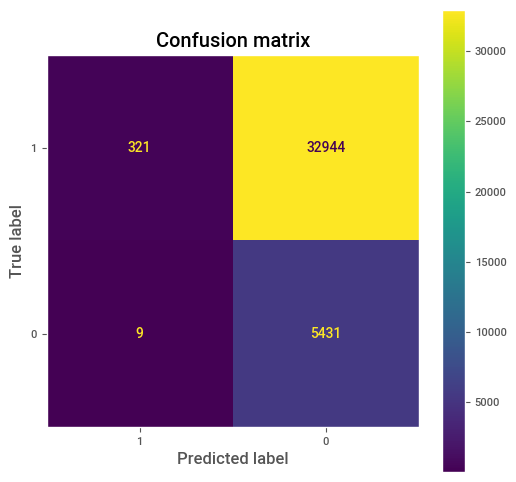

In [35]:
# Para nuestro nuestro caso tenemos.
cut_off_09 = pd.Series([1 if p_hat > 0.952 else 0 for p_hat in p_hat])
cm = confusion_matrix(true_label,cut_off_09, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
# Plot confusion matrix
fig, ax=plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.grid(False)
plt.title("Confusion matrix")
plt.show()

***Nuestro sistema no puede ser el perfecto :(***

- ***Paso 3.*** Siguiendo con nuestro sistema perfecto, cuando tomamos un ***cut-off menor que $p_0$***, debe suceder que $TPR$ no aumente ni disminuya ($TPR=1$), pero quien empezará a aumentar será $FPR$, hasta llegar al valor de 1. Este valor de $FPR=1$ se obtiene cuando el modelo precide todo 1, formando la recta horizontal de la curva ROC.

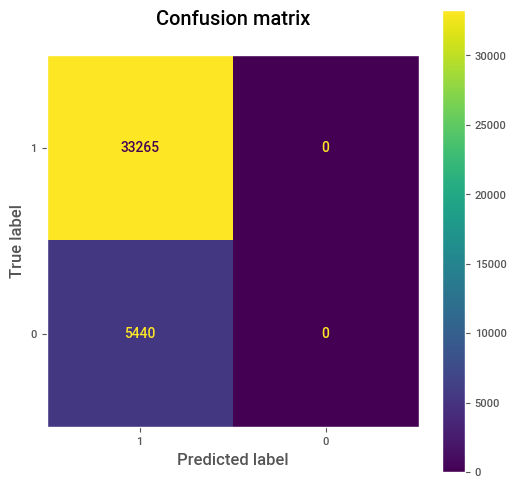

In [36]:
# Para nuestro nuestro caso tenemos.
all_ones = pd.Series([1 for p_hat in p_hat if p_hat >0])
cm = confusion_matrix(true_label,all_ones, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.grid(False)
plt.title("Confusion matrix\n")
plt.show()

Note que si el sistema es el ideal, el área bajo la curva ROC, llamada ***AUC*** es igual 1. Por lo tanto, ¿qué deseamos que suceda con nuestro sistema al realizar la curva ROC y encontrar su correspondiente ***AUC***?

### _**[AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)**_


Una forma de resumir toda la curva ROC es calculando el área bajo la curva (AUC). En términos generales, el AUC indica la ***probabilidad de que el clasificador asigne una probabilidad más alta a un ejemplo positivo (`completamente_pagado`) seleccionado al azar que a un ejemplo negativo (`dado_de_baja`) seleccionado al azar.***


In [37]:
# fpr: False-Positive-Rate se define como: 1-specificity. Es la proporción de los verdaderos 0's que 
# el modelo clasifica mal.
# tpr: True-positive-Rate: Es la proporción de los verdaderos 1's que el modelo clasifica bien.
fpr, tpr, thresholds = roc_curve(true_label, p_hat)

In [38]:
# auc
print("AUC para el modelo lr_logit2: {:.4f}".format(auc(fpr,tpr)))

AUC para el modelo lr_logit2: 0.6615


Este AUC de 0.6615 sugiere que el modelo tiene una capacidad de discriminación moderada. Esto significa que, en promedio, hay un 66.15% de probabilidad de que el modelo asigne una probabilidad más alta a un ejemplo positivo (`completamente_pagado`) que a un ejemplo negativo (`dado_de_baja`) seleccionado al azar.

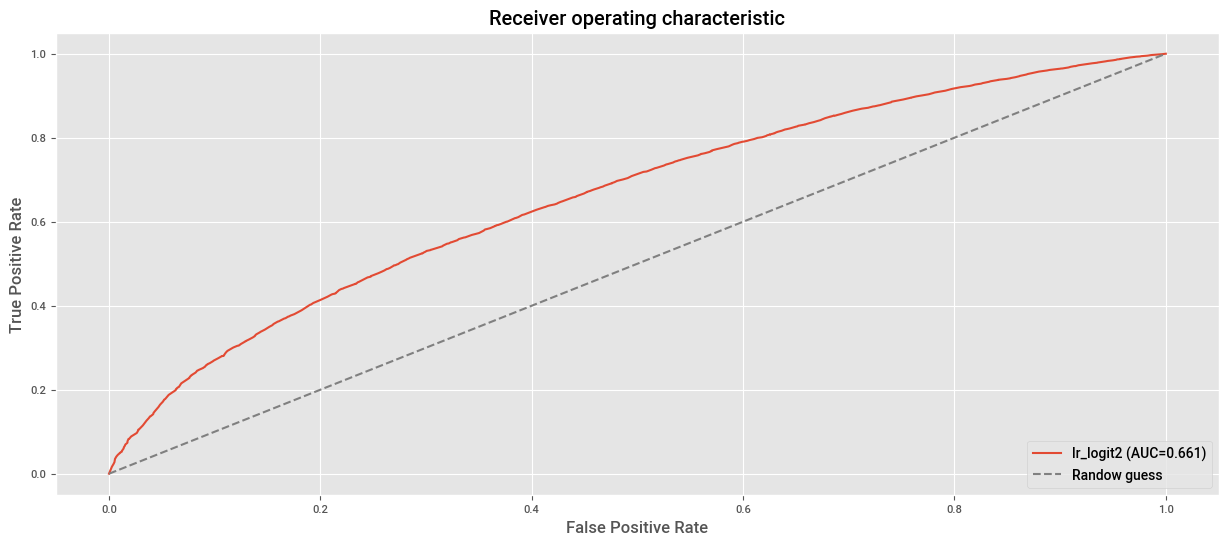

In [39]:
## Plot curva ROC.
fpr, tpr, _ = roc_curve(true_label, p_hat) # Esta en una celda anterior pero recuerde
roc_auc = auc(fpr, tpr)                             # que siempre lo debe usar para la construcción de
plt.plot(fpr, tpr, label="lr_logit2 (AUC={:.3f})".format(roc_auc),) # la curva ROC.
plt.plot((0,1), (0,1), ls="--", color="grey", label="Randow guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

En el plot anterior, la línea diagonal punteada corresponde a un clasificador que no mejora el azar. Un clasificador extremadamente eficaz ***tendrá un ROC que abraza la esquina superior izquierda; identificará correctamente muchos 1 sin clasificar erróneamente muchos 0 como 1.***

#### ***¿La verificación de la fuente de ingresos del solicitante debería considerarse un factor relevante para aprobar un préstamo?***


Una metodología para construir nuestro modelo final de clasificación binaria, es determinar cuales features son más viables para lograr el objetivo, es decir, un sistema que logre separar las clases, con la menor cantidad de errores.

Vamos a usar tablas de contingencias para buscar determinar la relación entre la variable Target con las demás categóricas.

In [40]:
def get_crosstab(df, feature):
       """
       Función que obtiene la pd.croostab de un pd.DataFrame con una columna fija (estado_del_prestamo)
       vs una variable categórica. Esta crosstab muestra el porcentaje real de la categoría
       objetivo (completamente_pagado) en cada categoría de la columna a contrastar.
       Input: df:= pd.DataFrame que contiene la columna "estado_del_prestamo"
              feature:= columna categóroca de df para realizar la crosstab.
       Output: pd.crosstab con las condiciones de la construcción.
       """
       crosstab = pd.crosstab(df[feature], df["estado_del_prestamo"], margins=True)
       crosstab["completamente_pagado(%)"] = round(crosstab["completamente_pagado"]/crosstab["All"]*100, 2)
       return crosstab.drop(columns="All")

In [41]:
get_crosstab(df_lr, "estado_de_verificacion")

estado_del_prestamo,completamente_pagado,dado_de_baja,completamente_pagado(%)
estado_de_verificacion,,,
no_verificado,14449,2050,87.58
verificado,10410,1977,84.04
verificado_con_fuente,8406,1413,85.61
All,33265,5440,85.94


***Que comentarios piensa que son acertados, basados en la tabla anterior?***

Por supuesto la herramienta que nos ayudará a verificar si estadísticamente hay relación o no entre la variable Target y esta variable será una prueba $\chi^{2}$ de independencia.

In [42]:
cross = pd.crosstab(df_lr["estado_de_verificacion"], df_lr["estado_del_prestamo"])
chi2, p, dof, ex = chi2_contingency(cross)
print("estado_de_verificacion: p-value of chisquare test =", p)

estado_de_verificacion: p-value of chisquare test = 6.88499828153605e-17


***Luego, las asociaciones entre `estado_del_prestamo` y `verification_status` son estadísticamente significativas.***

Tenga en cuenta que esta prueba sugiere que existe una diferencia significativa en la probabilidad de pago en los tres niveles, más no una tendencía.

Se hace necesario ajustar otras variables para eliminar posibles impactos de confusión. Si queremos saber si `estado_de_verificacion` realmente está asociado con `estado_del_prestamo` como lo indica la tabla de contingencia anterior, podemos estratificar la tabla de contingencia entre `estado_del_prestamo` y `estado_de_verificacion` por otras variables que también están asociadas con `estado_del_prestamo` .

In [43]:
def get_crosstab_stra(stra_var):
    """
    Genera una tabla de contingencia (crosstab) que muestra la relación entre una variable de estratificación
    y el estado del préstamo, incluyendo el porcentaje de préstamos completamente pagados.
    """
    ct_stra = pd.crosstab(
        index=[stra_var, df_lr["estado_de_verificacion"]], columns=df_lr["estado_del_prestamo"],
        margins=True
    )
    ct_stra["completamente_pagado (%)"]=round(ct_stra["completamente_pagado"]/ct_stra["All"]*100,2)
    
    return ct_stra.drop(columns="All").drop("All", level=0)

In [44]:
get_crosstab_stra(df_lr["tenencia_de_vivienda"])

estado_del_prestamo                          completamente_pagado  \
tenencia_de_vivienda estado_de_verificacion                         
alquiler             no_verificado                           7133   
                     verificado                              4290   
                     verificado_con_fuente                   4332   
hipoteca             no_verificado                           6064   
                     verificado                              5480   
                     verificado_con_fuente                   3443   
otro                 no_verificado                             42   
                     verificado                                29   
                     verificado_con_fuente                      9   
propia               no_verificado                           1210   
                     verificado                               611   
                     verificado_con_fuente                    622   

estado_del_prestamo                          dado_de_baja  \
tenencia_de_vivienda estado_de_verificacion                 
alquiler             no_verificado                   1072   
                     verificado                       865   
                     verificado_con_fuente            815   
hipoteca             no_verificado                    798   
                     verificado                       983   
                     verificado_con_fuente            487   
otro                 no_verificado                     10   
                     verificado                         7   
                     verificado_con_fuente              1   
propia               no_verificado                    170   
                     verificado                       122   
                     verificado_con_fuente            110   

estado_del_prestamo                          completamente_pagado (%)  
tenencia_de_vivienda estado_de_verificacion                            
alquiler             no_verificado                              86.93  
                     verificado                                 83.22  
                     verificado_con_fuente                      84.17  
hipoteca             no_verificado                              88.37  
                     verificado                                 84.79  
                     verificado_con_fuente                      87.61  
otro                 no_verificado                              80.77  
                     verificado                                 80.56  
                     verificado_con_fuente                      90.00  
propia               no_verificado                              87.68  
                     verificado                                 83.36  
                     verificado_con_fuente                      84.97

***Que comentarios piensa que son acertados, basados en la tabla anterior?***

In [45]:
get_crosstab_stra(df_lr["plazo"])

estado_del_prestamo              completamente_pagado  dado_de_baja  \
plazo    estado_de_verificacion                                       
36 meses no_verificado                          12574          1580   
         verificado                              6505           805   
         verificado_con_fuente                   6132           688   
60 meses no_verificado                           1875           470   
         verificado                              3905          1172   
         verificado_con_fuente                   2274           725   

estado_del_prestamo              completamente_pagado (%)  
plazo    estado_de_verificacion                            
36 meses no_verificado                              88.84  
         verificado                                 88.99  
         verificado_con_fuente                      89.91  
60 meses no_verificado                              79.96  
         verificado                                 76.92  
         verificado_con_fuente                      75.83

- ***Que comentarios piensa que son acertados, basados en la tabla anterior?***
- ***Proporciones comentarios generales de los hallazgos.***

***Pregunta.***

Vamos a suponer que los usuarios que NO tienen los ingresos verificados, tiene más probabilidad de pedir préstamos a CORTO PLAZO en comparación con los usuarios con ingresos verificados. Adicionalmente, que los usuarios con préstamos a corto plazo tiene más probabilidades de pagar sus deudas.

***Si fuera el caso que `estado_de_verificacion` no tiene efecto en la probabilidad de PAGAR la deuda. ¿Los usuarios sin ingresos verificados están en el margen más probable a pagar su deuda?***


In [46]:
# Modelo con variables numéricas + estado_de_verificacion
df3 = df_lr.copy()
df3 = df3[["tasa_de_interes", "ingreso_anual", "estado_del_prestamo", "monto_del_prestamo", "estado_de_verificacion"]]
df3["estado_del_prestamo"] = df3["estado_del_prestamo"].apply(lambda x: 0 if x == "dado_de_baja" else 1)
df3["estado_de_verificacion"] = df3["estado_de_verificacion"].astype("category")
#
lr_logit3 = smf.logit(
    formula="estado_del_prestamo ~ tasa_de_interes + ingreso_anual + monto_del_prestamo + estado_de_verificacion",
    data=df3
).fit()

print(lr_logit3.summary())

Optimization terminated successfully.
         Current function value: 0.383396
         Iterations 7
                            Logit Regression Results                           
Dep. Variable:     estado_del_prestamo   No. Observations:                38705
Model:                           Logit   Df Residuals:                    38699
Method:                            MLE   Df Model:                            5
Date:                 Sun, 03 Nov 2024   Pseudo R-squ.:                 0.05558
Time:                         20:30:47   Log-Likelihood:                -14839.
converged:                        True   LL-Null:                       -15713.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                 

In [47]:
# Calculamos el valor del AUC
p_hat3 = lr_logit3.predict(df3.drop(columns=["estado_del_prestamo"]))
fpr3, tpr3, thresholds3 = roc_curve(df3["estado_del_prestamo"], p_hat3)
print(f"AUC: {auc(fpr3, tpr3):.5f}")

AUC: 0.67345


### ***Modelo completo.***

Vamos a incorporar todas estas variables en el modelo logístico junto con `verification_status` y veamos si la tendencia decreciente asociada con `verification_status` todavía se mantiene.

In [48]:
df_full = df_lr.copy()
y = df_full["estado_del_prestamo"]

df_cate = df_full.select_dtypes("object").drop(columns=["estado_del_prestamo"])
for column in df_cate.columns:
  df_cate[column] = df_cate[column].astype("category")
df_number=df_full.select_dtypes("number")

X = pd.concat([y, df_cate, df_number], axis=1)
X["estado_del_prestamo"] = X["estado_del_prestamo"].apply(lambda x: 0 if x == "dado_de_baja" else 1)

formula = ("""estado_del_prestamo ~ tasa_de_interes + ingreso_anual + monto_del_prestamo +"""
"""estado_de_verificacion + anios_de_experiencia_laboral + tenencia_de_vivienda + proposito + plazo + calificacion""")
          
lr_full = smf.logit(formula=formula, data=X).fit()
print(lr_full.summary())
print()
##
p_hatF = lr_full.predict(X.drop(columns=["estado_del_prestamo"]))
fpr, tpr, _ = roc_curve(X["estado_del_prestamo"], p_hatF)
print("AUC:", auc(fpr, tpr))

Optimization terminated successfully.
         Current function value: 0.377925
         Iterations 7
                            Logit Regression Results                           
Dep. Variable:     estado_del_prestamo   No. Observations:                38705
Model:                           Logit   Df Residuals:                    38666
Method:                            MLE   Df Model:                           38
Date:                 Sun, 03 Nov 2024   Pseudo R-squ.:                 0.06906
Time:                         20:30:49   Log-Likelihood:                -14628.
converged:                        True   LL-Null:                       -15713.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                 

Con los resultados anteriores podemos comentar lo siguiente:

1. No hay evidencia que sustente la asociación entre la probabilidad de pago y el estado de verificación después de considerar otras variables.

2. Los ***odds de pago*** en los usuarios con grado B (`calificacion B`) disminuyen un $24\%$ aproximadamente en comparación con los usurios de grado A (`grade A`) teniendo en cuenta todas las varibles, esto pues $$exp(-0.2728)=0.761$$

Note que ahora los coeficientes de regresión para `estado_de_verificacion` son positvos comparados con el modelo `lr_logit3` aunque los $p$ siguen siendo grandes. Esto indica que después de ajustar todas las demás variables en el modelo, `estado_de_verificacion` sigue sin mostrar diferencias asociadas con la chance de pago. ***¿Qué variables de confusión fueron las responsables de introducir la tendencia decreciente inicial?***

In [49]:
px.box(df_lr, y="monto_del_prestamo", x="estado_de_verificacion", color="estado_de_verificacion", template="plotly_white").show()

In [50]:
res = pd.crosstab(df_lr["estado_de_verificacion"], df_lr["anios_de_experiencia_laboral"])
round(res.div(res.sum(axis=1),axis=0)*100, 4)

anios_de_experiencia_laboral,1 año,10+ años,2 años,3 años,4 años,5 años,6 años,7 años,8 años,9 años,< 1 año
estado_de_verificacion,,,,,,,,,,,
no_verificado,9.4127,20.1285,12.4311,11.0976,8.9763,8.5945,5.6731,4.4427,3.8245,3.3335,12.0856
verificado,6.9185,28.9820,10.0186,9.8087,8.9368,8.3475,5.8771,4.7227,4.0849,3.3180,8.9852
verificado_con_fuente,8.5243,20.2465,11.2231,10.7139,8.7178,8.4836,5.7745,4.6542,3.5441,3.0349,15.0830


***Comentarios:***

1. La tendencia marginal es que las personas con ingresos verificados tienden a pedir préstamos con tasas de interés más altas.

2. La tendencia marginal es que las personas con ingresos verificados tienden a pedir préstamos con mayores cuantias.

3. La tendencia marginal es que las personas con ingresos verificados tienden a tener un empleo más prolongado.

Todo parece indicar que la inclusión de `estado_de_verificacion` es no necesaria. Aunque el $p$-valor es una medida de la importancia o no de la inclusión de una feature al modelo, no siempre es la única manera de decidir que feature o no incluir, el mismo coeficiente puede ser un factor de no inclusión (piense en ***odds*** cercanos a 1). Tenga un cuenta que la tarea principal finalmente es la clasificación de la manera más "correcta" posible, luego basaremos nuestra decisión final en la curva ROC y su área bajo la curva.

In [51]:
# MODELO SIN "estado_de_verificacion"
formula_sin_ev = (
    """estado_del_prestamo ~ tasa_de_interes + ingreso_anual + monto_del_prestamo + anios_de_experiencia_laboral +"""
    """tenencia_de_vivienda + proposito + plazo + calificacion"""
)

lr_full1 = smf.logit(formula=formula_sin_ev, data=X).fit()
print(lr_full1.summary())

Optimization terminated successfully.
         Current function value: 0.377930
         Iterations 7
                            Logit Regression Results                           
Dep. Variable:     estado_del_prestamo   No. Observations:                38705
Model:                           Logit   Df Residuals:                    38668
Method:                            MLE   Df Model:                           36
Date:                 Sun, 03 Nov 2024   Pseudo R-squ.:                 0.06905
Time:                         20:30:50   Log-Likelihood:                -14628.
converged:                        True   LL-Null:                       -15713.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                               

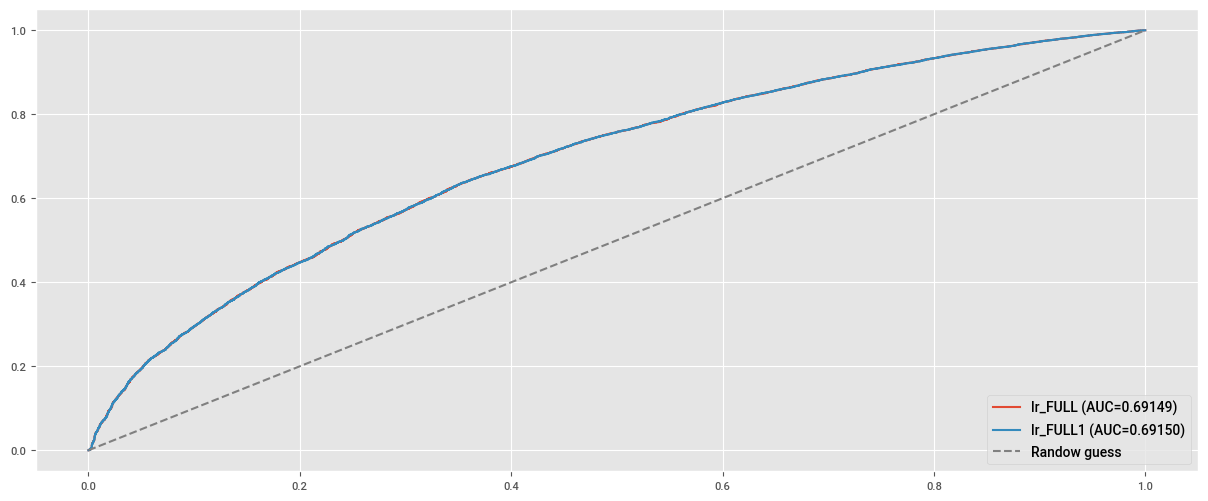

In [52]:
# Curva ROC modelo FULL
predict = lr_full.predict(X.drop(columns=["estado_del_prestamo"]))
fpr, tpr, _ = roc_curve(X["estado_del_prestamo"], predict)
plt.plot(fpr, tpr, label=f"lr_FULL (AUC={auc(fpr, tpr):.5f})")

# Curva ROC modelo FULL SIN "estado_de_verificacion"
predict1 = lr_full1.predict(X.drop(columns=["estado_del_prestamo"]))
fpr1, tpr1, _ =roc_curve(X["estado_del_prestamo"], predict1)
plt.plot(fpr1, tpr1, label=f"lr_FULL1 (AUC={auc(fpr1, tpr1):.5f})")
plt.plot((0,1), (0,1), ls="--", color="grey", label="Randow guess")
plt.legend(loc="lower right")
plt.show()

***Encontramos que el AUC para el modelo con `estado_de_verificacion` incluido es el mismo que el modelo sin `estado_de_verificacion` (0.69). Dado que siempre queremos que nuestro modelo sea lo más simple posible, no debemos incluir `estado_de_verificacion` como una variable al predecir si es probable que un usuario pague su deuda.***

# _**Anexo: [Logistic Regression sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)**_

In [53]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Preparamos la Data
df_lr_sk = pd.read_parquet(url_base + "Logistic_Regression_1.parquet",)
df_lr_sk["tasa_de_interes"] = df_lr_sk["tasa_de_interes"].str.replace("%", "").astype("float")
df_lr_sk.drop(columns=["estado_de_verificacion"], inplace=True)
X, y = pd.get_dummies(df_lr_sk.drop(columns=["estado_del_prestamo"]), drop_first=True), df_lr_sk["estado_del_prestamo"]
y = label_binarize(y, classes=["dado_de_baja", "completamente_pagado"])

X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=123, test_size=0.2, stratify=y)

# Instanciamos la clase y entrenamos el modelo.
clf = LogisticRegression(C=1e10, solver="newton-cg")
clf.fit(X_train,y_train)

LogisticRegression(C=10000000000.0, solver='newton-cg')

In [54]:
# Coeficientes
coefs = np.concatenate((clf.intercept_.reshape(1,1), clf.coef_), axis=1)
list_betas=["intercept"]
list_betas.extend(X_train.columns)
pd.DataFrame(np.transpose(coefs), index=list_betas, columns=["betas"])

,betas
intercept,3.507635
ingreso_anual,0.000006
tasa_de_interes,-0.121629
monto_del_prestamo,-0.000002
anios_de_experiencia_laboral_10+ años,-0.059191
anios_de_experiencia_laboral_2 años,0.157375
anios_de_experiencia_laboral_3 años,0.141894
anios_de_experiencia_laboral_4 años,0.109889
anios_de_experiencia_laboral_5 años,0.063956
anios_de_experiencia_laboral_6 años,0.086737


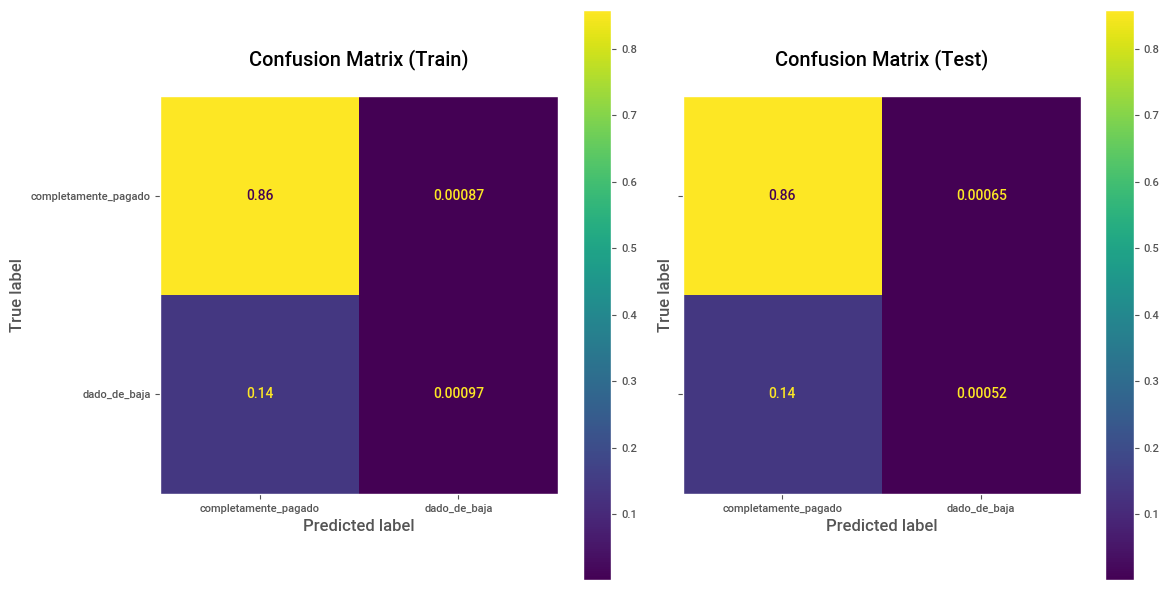

In [55]:
# Predicciones y Matriz de confusión sobre Train.
y_pred_train = clf.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred_train, labels=[1, 0], normalize="all")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=["completamente_pagado", "dado_de_baja"])

# Predicciones y Matriz de confusión sobre Test.
y_pred_test = clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test, labels=[1, 0], normalize="all")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["completamente_pagado", "dado_de_baja"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
disp_train.plot(ax=ax1,)
ax1.set_title("Confusion Matrix (Train)\n")
ax1.grid(False)

disp_test.plot(ax=ax2)
ax2.set_title("Confusion Matrix (Test)\n")
ax2.grid(False)

plt.tight_layout()
plt.show()

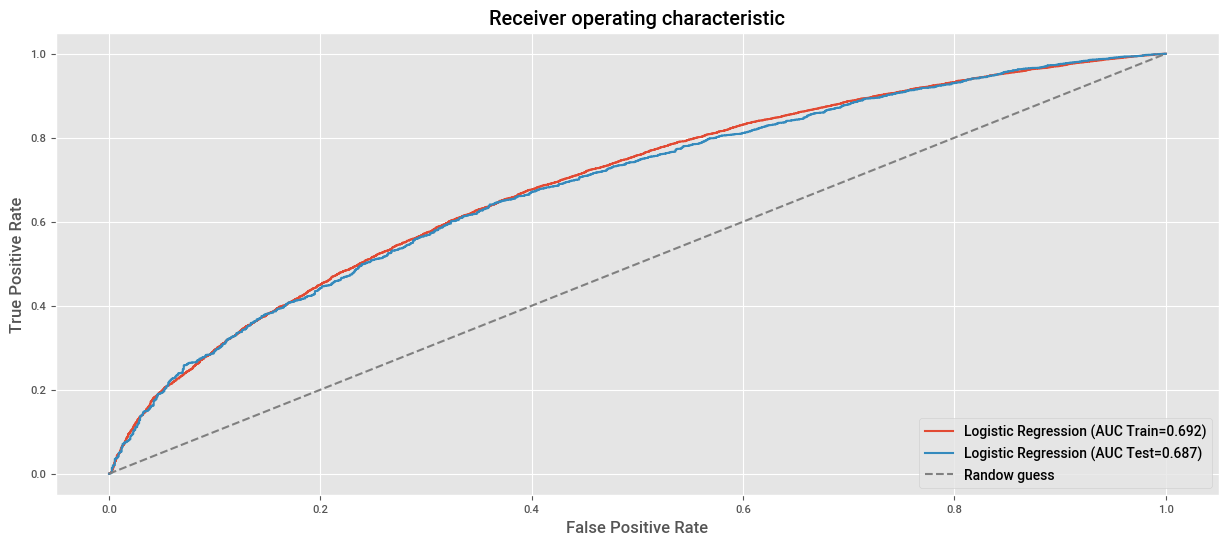

In [56]:
# AUC en train.
fpr, tpr, _ = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC Train={roc_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")

# AUC en test.
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC Test={roc_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")

plt.plot((0,1), (0,1), ls="--", color="grey", label="Randow guess")
plt.legend(loc="lower right")
plt.show()